# Imports

In [1]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, RawEVLPDataset, ProcessedEVLPDataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init

import numpy as np
import tqdm as tqdm
from scipy.stats import pearsonr


# Device Setup

In [2]:
device = torch.device("cuda")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load Data

In [3]:
def load_data(seed):   
    train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=seed
    )
    train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=seed
    )

    train_dataset = ProcessedEVLPDataset(train_lung_ids)
    val_dataset = ProcessedEVLPDataset(val_lung_ids)
    test_dataset = ProcessedEVLPDataset(test_lung_ids)
    print(len(train_dataset), len(val_dataset), len(test_dataset))

    return train_dataset, val_dataset, test_dataset

In [4]:
train_dataset, val_dataset, test_dataset = load_data(8)

2023-12-03 21:39:18,502 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301
2023-12-03 21:39:18,535 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:39:18,550 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668


144 5 5


# Data Visualization

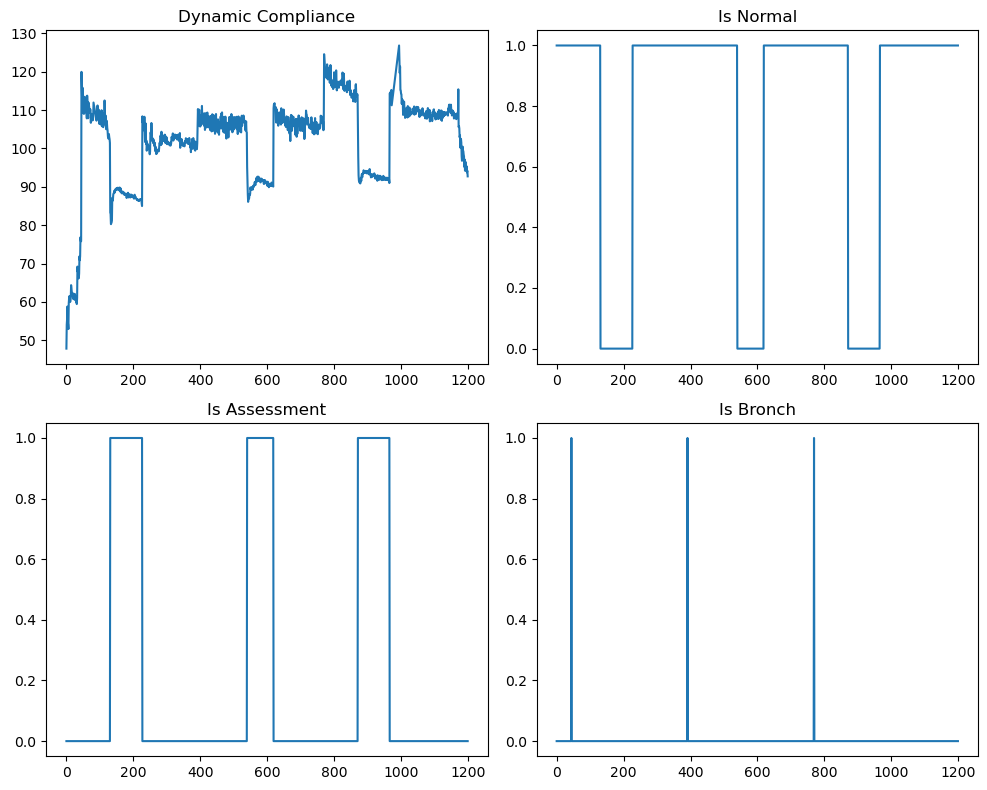

In [5]:
a = test_dataset[2]['Dy_comp']
c = test_dataset[2]['Is_normal']
b = test_dataset[2]['Is_assessment']
d = test_dataset[2]['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [6]:
def find_last(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [7]:
def right_pad_sequence(sequence, target_length):
    current_length = len(sequence)
    total_padding = target_length - current_length
    if total_padding <= 0:
        return sequence
    pad_after = total_padding

    return np.pad(sequence, (0, pad_after), mode='edge')
len(right_pad_sequence(train_dataset[0]['Dy_comp'][:1+1], 1415))


1415

In [8]:
def find_max_length_x():
    m = [0,0,0]
    for i in train_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        if metric_start > m[0]:
            m[0]=metric_start+1
    for i in val_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        if metric_start > m[1]:
            m[1]=metric_start+1
    for i in test_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        if metric_start > m[2]:
            m[2]=metric_start+1
    return max(m)
max_l = find_max_length_x()
max_l

1416

In [9]:
def find_max_length_y(dataset):
    m = 0
    for i in dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins
        # Find the first assessment period that starts after the last bronch occurrence
        first_assessment_after_bronch = None
        for change in changes:
            if change > metric_start:
                first_assessment_after_bronch = change
                break
        if metric_start< (len(i['Is_assessment']) - 1) * 0:
            continue
        if first_assessment_after_bronch is None:
            first_assessment_after_bronch = len(i['Is_assessment']) - 1
        if len(i['Dy_comp'][metric_start:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
            continue
        if len(i['Dy_comp'][metric_start:first_assessment_after_bronch]) > m:
            m = first_assessment_after_bronch - metric_start
    return m + 1
max_y_train = find_max_length_y(train_dataset)
max_y_val = find_max_length_y(val_dataset)
max_y_test = find_max_length_y(test_dataset)
max_y = max(max_y_train, max_y_val, max_y_test)
max_y

368

In [10]:
def set_dataset(dataset, max_l, max_y):
    X_dc = []
    X_is_normal = []
    X_is_bronch = []

    Y = []
    Y_len = []

    for i in dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins
        # Find the first assessment period that starts after the last bronch occurrence
        first_assessment_after_bronch = None
        for change in changes:
            if change > metric_start:
                first_assessment_after_bronch = change
                break
        if metric_start< (len(i['Is_assessment']) - 1) * 0:
            continue

        if first_assessment_after_bronch is None:
            first_assessment_after_bronch = len(i['Is_assessment']) - 1
        if len(i['Dy_comp'][metric_start:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
            continue

        # 做padding，保证长度一致，用最长的长度
        X_dc.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], max_l))
        X_is_normal.append(right_pad_sequence(i['Is_normal'][:metric_start+1], max_l))
        X_is_bronch.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], max_l))

        Y_len.append(len(i['Dy_comp'][metric_start:first_assessment_after_bronch])) # 记录长度，用于计算loss)
        Y.append(right_pad_sequence(i['Dy_comp'][metric_start:first_assessment_after_bronch], max_y))

    print(f"length is {len(X_dc)}")    
    assert len(X_dc) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

    X_dc = np.array(X_dc).reshape(-1, max_l)
    X_is_normal = np.array(X_is_normal).reshape(-1, max_l)
    X_is_bronch = np.array(X_is_bronch).reshape(-1, max_l)
    Y = torch.from_numpy(np.array(Y)).float()
    Y_len = torch.from_numpy(np.array(Y_len)).int()

    X_combined = np.stack([X_dc, X_is_normal, X_is_bronch], axis=1)  # Shape becomes [N, 3, 1470]
    X_combined = torch.from_numpy(X_combined).float()

    return X_combined, Y, Y_len



# Set Dataset

In [11]:
class EVLPDataset(Dataset):
    def __init__(self, X_combined, Y, Y_len):
        self.X_combined = X_combined
        self.Y = Y
        self.Y_len = Y_len

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X_combined[idx], self.Y[idx], self.Y_len[idx]

In [12]:
x_combine_train, y_train, y_len_train = set_dataset(train_dataset, max_l, max_y)
x_combine_val, y_val, y_len_val = set_dataset(val_dataset, max_l, max_y)
x_combine_test, y_test, y_len_test = set_dataset(test_dataset, max_l, max_y)

train_loader = DataLoader(EVLPDataset(x_combine_train, y_train, y_len_train), batch_size=32, shuffle=True)
val_loader = DataLoader(EVLPDataset(x_combine_val, y_val, y_len_val), batch_size=1, shuffle=False)
test_loader = DataLoader(EVLPDataset(x_combine_test, y_test, y_len_test), batch_size=1, shuffle=False)

length is 144
length is 5
length is 5


# PyTorch

In [13]:
class CNN(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=4, padding=0):
        super().__init__()

        self.conv1 = torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv2 = nn.Conv1d(num_filters, 128, kernel_size=kernel, padding=padding)
        self.conv2.weight.data.uniform_(0, 0.01)

        self.conv_seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        conv_output_size = self._calculate_conv_output_size(max_l, kernel, padding)
        self.fc1 = torch.nn.Linear(conv_output_size, 128)
        init.uniform_(self.fc1.weight, -0.01, 0.01)

        self.fc_seq = torch.nn.Sequential( 
            self.fc1,
            torch.nn.ReLU()
        )

        self.final_layer = nn.Linear(in_features=128, out_features=max_y)
        init.uniform_(self.final_layer.weight, -0.01, 0.01)

    def _calculate_conv_output_size(self, input_length, kernel, padding):
        size = (input_length - kernel + 2 * padding) + 1
        size = size // 2
        size = (size - kernel + 2 * padding) + 1
        size = size // 2
        return size * 128  
    
    def forward(self, x):
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = self.fc_seq(x)
        x = self.final_layer(x)
        return x

In [14]:
class DNN_mean_prediction(nn.Module):
    def __init__(self, sequence_length, num_filters=64, num_in_channels=3):
        super(DNN_mean_prediction, self).__init__()

        self.linear1 = nn.Linear(num_in_channels * sequence_length, num_filters)
        self.linear2 = nn.Linear(num_filters, 128)
        self.linear3 = nn.Linear(128, 256)
        self.final_layer = nn.Linear(in_features=256, out_features=1)

        nn.init.uniform_(self.linear1.weight, a=0.001, b=0.01)
        nn.init.uniform_(self.linear2.weight, a=0.001, b=0.01)
        nn.init.uniform_(self.linear3.weight, a=0.001, b=0.01)
        nn.init.uniform_(self.final_layer.weight, a=0.001, b=0.01)

        self.conv_seq = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            self.linear2,
            nn.ReLU(),
            self.linear3,
            nn.ReLU(),
            self.final_layer)

        

    def forward(self, x):
        # Reshape the input tensor to [batch_size, num_in_channels * 1470]
        x = x.view(x.size(0), -1)

        x = self.conv_seq(x)
        return x

In [15]:
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.cnn = CNN()
        self.dnn = DNN_mean_prediction(sequence_length=max_l)

    def forward(self, x):
        dnn_output = self.dnn(x)

        dnn_output_expanded = dnn_output.unsqueeze(-1)  # Size: [32, 1, 1]
        dnn_output_expanded = dnn_output_expanded.expand(-1, -1, max_l)  # Size: [32, 1, 1416]

        combined_tensor = torch.cat((x, dnn_output_expanded), dim=1)
        cnn_output = self.cnn(combined_tensor)
        
        cnn_output_mean = torch.mean(cnn_output, dim=1, keepdim=True)
        normalized_cnn_output = cnn_output - cnn_output_mean
        combined_output = normalized_cnn_output + dnn_output

        return combined_output


In [16]:
def train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs):

    model.train()
    epoch_losses = []
    val_losses = []

    val_target = []
    val_predict = []

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, y, lengths in train_loader:
            inputs, y = inputs.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
            mask = mask.to(device)
            outputs_masked = torch.masked_select(outputs, mask).to(device)
            y_masked = torch.masked_select(y, mask).to(device)

            loss = criterion(outputs_masked, y_masked)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for inputs, y, lengths in val_loader:
                inputs, y = inputs.to(device), y.to(device)
                outputs = model(inputs)

                mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
                mask = mask.to(device)
                outputs_masked = torch.masked_select(outputs, mask).to(device)
                y_masked = torch.masked_select(y, mask).to(device)

                loss = criterion(outputs_masked, y_masked)

                val_loss = criterion(outputs_masked, y_masked)
            
                if epoch == epochs - 1:
                    val_target.append(y[:, :lengths])
                    val_predict.append(outputs[:, :lengths])
    
                running_val_loss += val_loss.item()

            average_val_loss = running_val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}, Training Loss: {average_loss}, Validation Loss: {average_val_loss}")

        if epoch == epochs - 1:
            # Flatten the validation target and prediction lists
            flat_val_target = torch.cat([t.flatten() for t in val_target])
            flat_val_predict = torch.cat([p.flatten() for p in val_predict])

            # Calculate Pearson's R
            pearson_r_val, _ = pearsonr(flat_val_target.cpu().numpy(), flat_val_predict.cpu().numpy())
            print(f"Epoch {epoch + 1}, Pearson's R: {pearson_r_val}, Validation Loss: {average_val_loss}")

        model.train()

    # Determine the number of rows and columns for subplots
    num_samples = len(val_predict)
    cols = 2
    rows = num_samples // cols + (num_samples % cols > 0)

    # Plotting
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.plot(val_predict[i][0].cpu().numpy(), label='Predicted')
        plt.plot(val_target[i][0].cpu().numpy(), label='Target', alpha=0.7)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='blue', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, marker='o', color='red', label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    model.eval()

    output_ls = []
    target_ls = []

    test_loss = 0
    with torch.no_grad():
        for data, y, lengths in test_loader:
            data, y = data.to(device), y.to(device)
            outputs = model(data)
            
            mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
            mask = mask.to(device)
            outputs_masked = torch.masked_select(outputs, mask).to(device)
            y_masked = torch.masked_select(y, mask).to(device)

            output_ls.append(outputs[:, :lengths])
            target_ls.append(y[:, :lengths])

            case_loss = criterion(outputs_masked, y_masked).item()
            test_loss += case_loss

    test_loss /= len(test_loader.dataset)

    # Flatten the test target and prediction lists
    flat_test_target = torch.cat([t.flatten() for t in target_ls])
    flat_test_predict = torch.cat([p.flatten() for p in output_ls])
    pearson_r, _ = pearsonr(flat_test_target.cpu().numpy(), flat_test_predict.cpu().numpy())

    # Determine the number of rows and columns for subplots
    num_samples = len(output_ls)
    cols = 2
    rows = num_samples // cols + (num_samples % cols > 0)

    # Plotting
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.plot(output_ls[i][0].cpu().numpy(), label='Predicted')
        plt.plot(target_ls[i][0].cpu().numpy(), label='Target', alpha=0.7)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Test set: Average loss: {test_loss:.4f}, Pearson\'s R: {pearson_r}')
    return average_loss, average_val_loss, test_loss, pearson_r_val, pearson_r

## Performance Comparison

Total trainable parameters in the model: 6153841
Epoch 20, Training Loss: 282.3398376464844, Validation Loss: 106.59803428649903
Epoch 40, Training Loss: 258.46473693847656, Validation Loss: 92.7144832611084
Epoch 60, Training Loss: 197.1085235595703, Validation Loss: 117.11949863433838
Epoch 80, Training Loss: 187.16126251220703, Validation Loss: 60.91943435668945
Epoch 100, Training Loss: 183.87991943359376, Validation Loss: 63.29136238098145
Epoch 120, Training Loss: 217.69501647949218, Validation Loss: 327.3417221069336
Epoch 140, Training Loss: 461.9059631347656, Validation Loss: 426.8694412231445
Epoch 160, Training Loss: 206.39437255859374, Validation Loss: 52.727281761169436
Epoch 180, Training Loss: 147.46682891845703, Validation Loss: 55.83028793334961
Epoch 200, Training Loss: 169.59722290039062, Validation Loss: 112.47241897583008
Epoch 200, Pearson's R: 0.9844391458886483, Validation Loss: 112.47241897583008


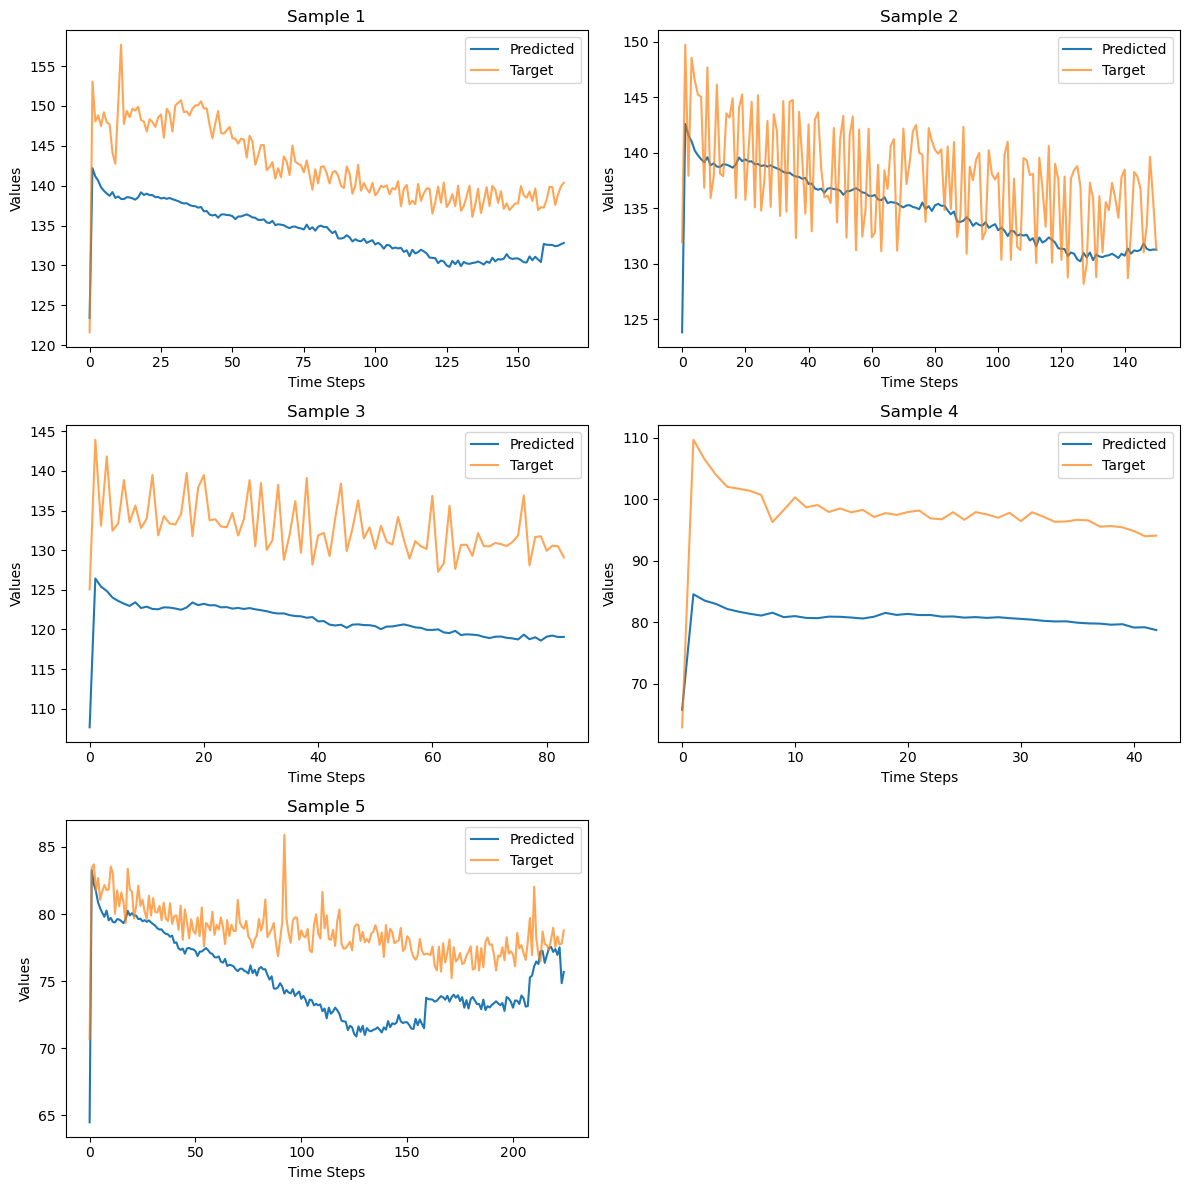

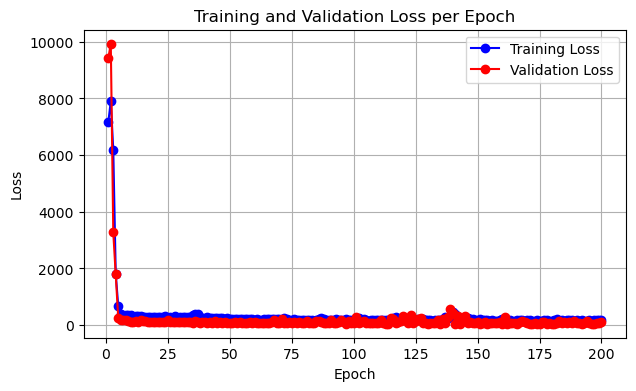

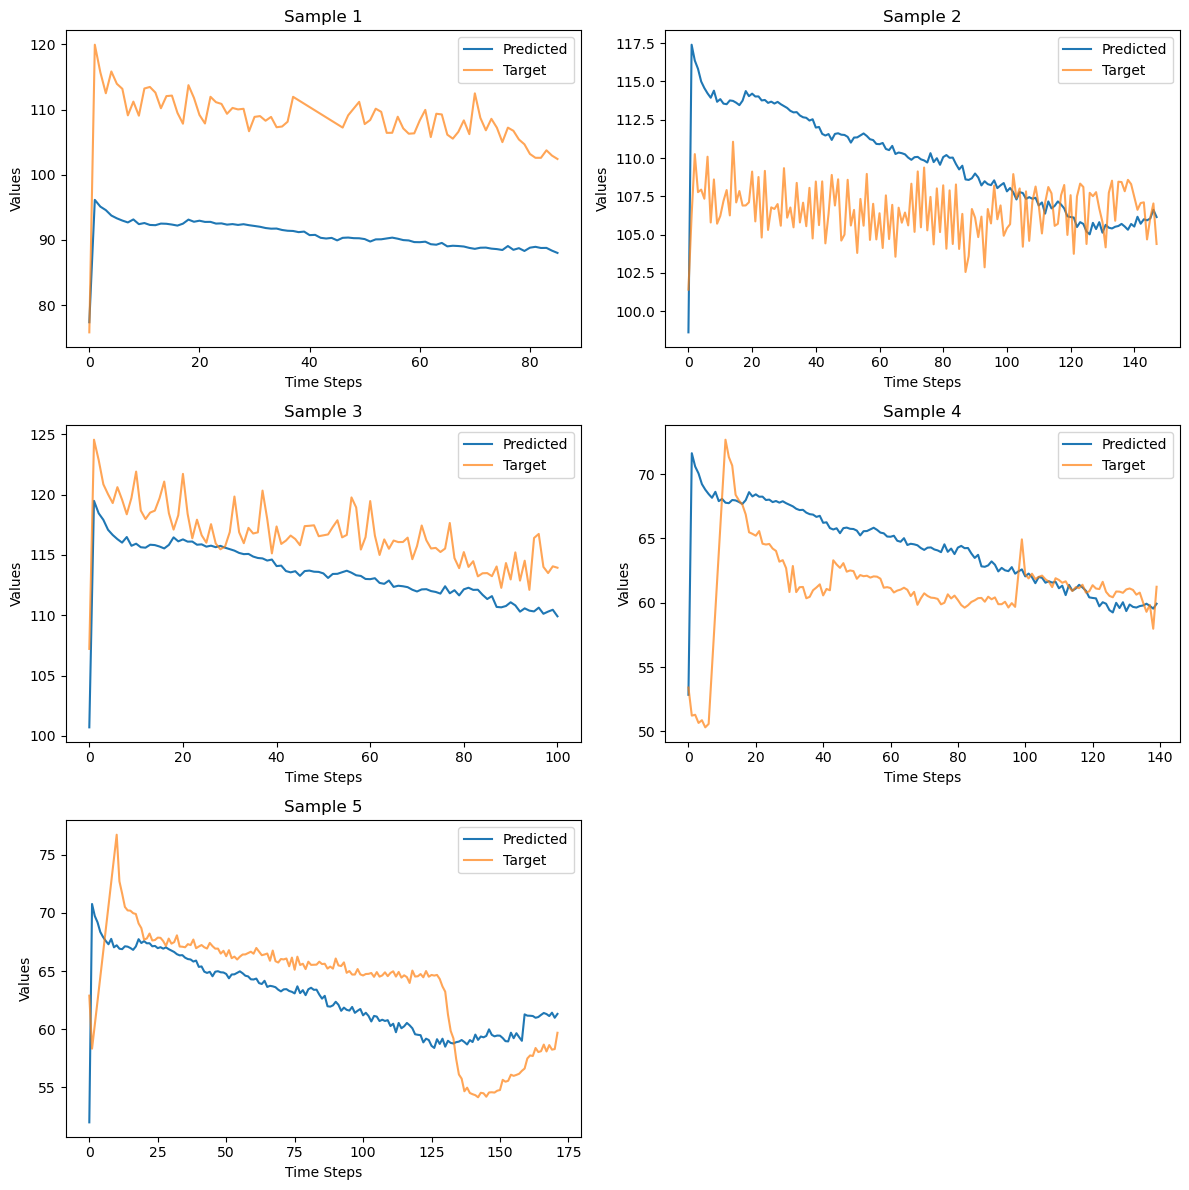

Test set: Average loss: 80.3628, Pearson's R: 0.9505532696695972


(169.59722290039062,
 112.47241897583008,
 80.36278553009033,
 0.9844391458886483,
 0.9505532696695972)

In [17]:
epochs = 200
model = HybridModel().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters in the model: {total_params}")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = nn.MSELoss()

train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

Epoch 20, Training Loss: 277.15582885742185, Validation Loss: 110.88845405578613
Epoch 40, Training Loss: 274.7324279785156, Validation Loss: 321.9853832244873
Epoch 60, Training Loss: 184.58551635742188, Validation Loss: 98.5147861480713
Epoch 80, Training Loss: 198.06935424804686, Validation Loss: 143.33862991333007
Epoch 100, Training Loss: 233.64703979492188, Validation Loss: 102.99301948547364
Epoch 120, Training Loss: 196.80312805175782, Validation Loss: 443.2464340209961
Epoch 140, Training Loss: 479.26471557617185, Validation Loss: 212.5596710205078
Epoch 160, Training Loss: 185.59119720458983, Validation Loss: 111.40675201416016
Epoch 180, Training Loss: 158.83780822753906, Validation Loss: 68.73074712753296
Epoch 200, Training Loss: 226.3851745605469, Validation Loss: 191.28479375839234
Epoch 200, Pearson's R: 0.9654910599958852, Validation Loss: 191.28479375839234


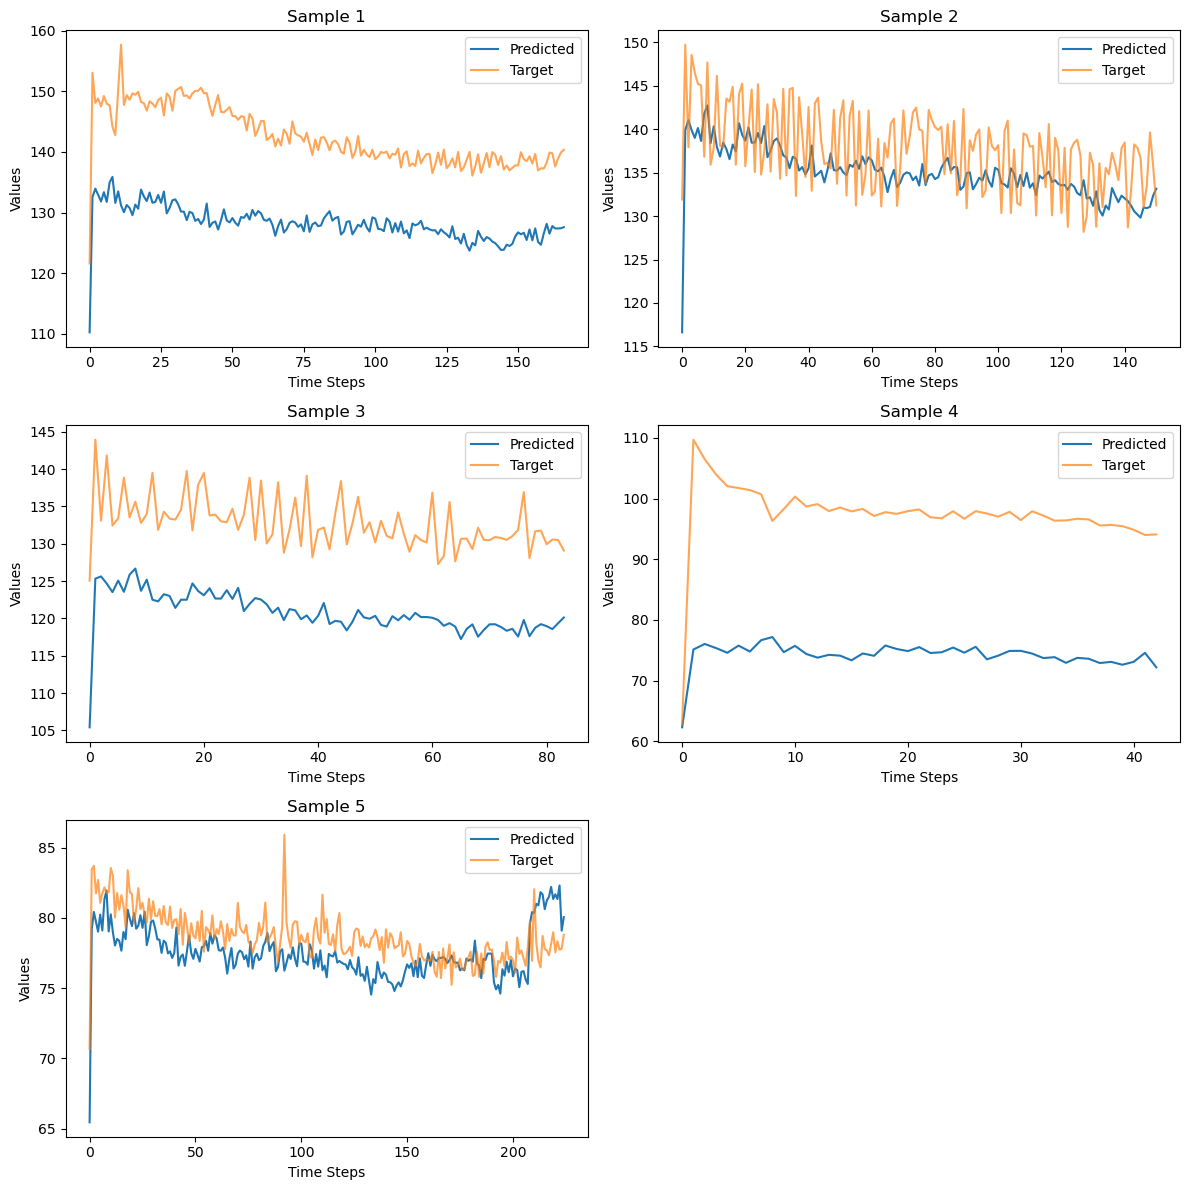

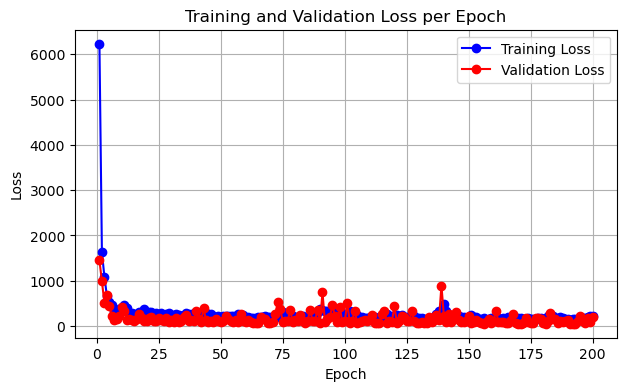

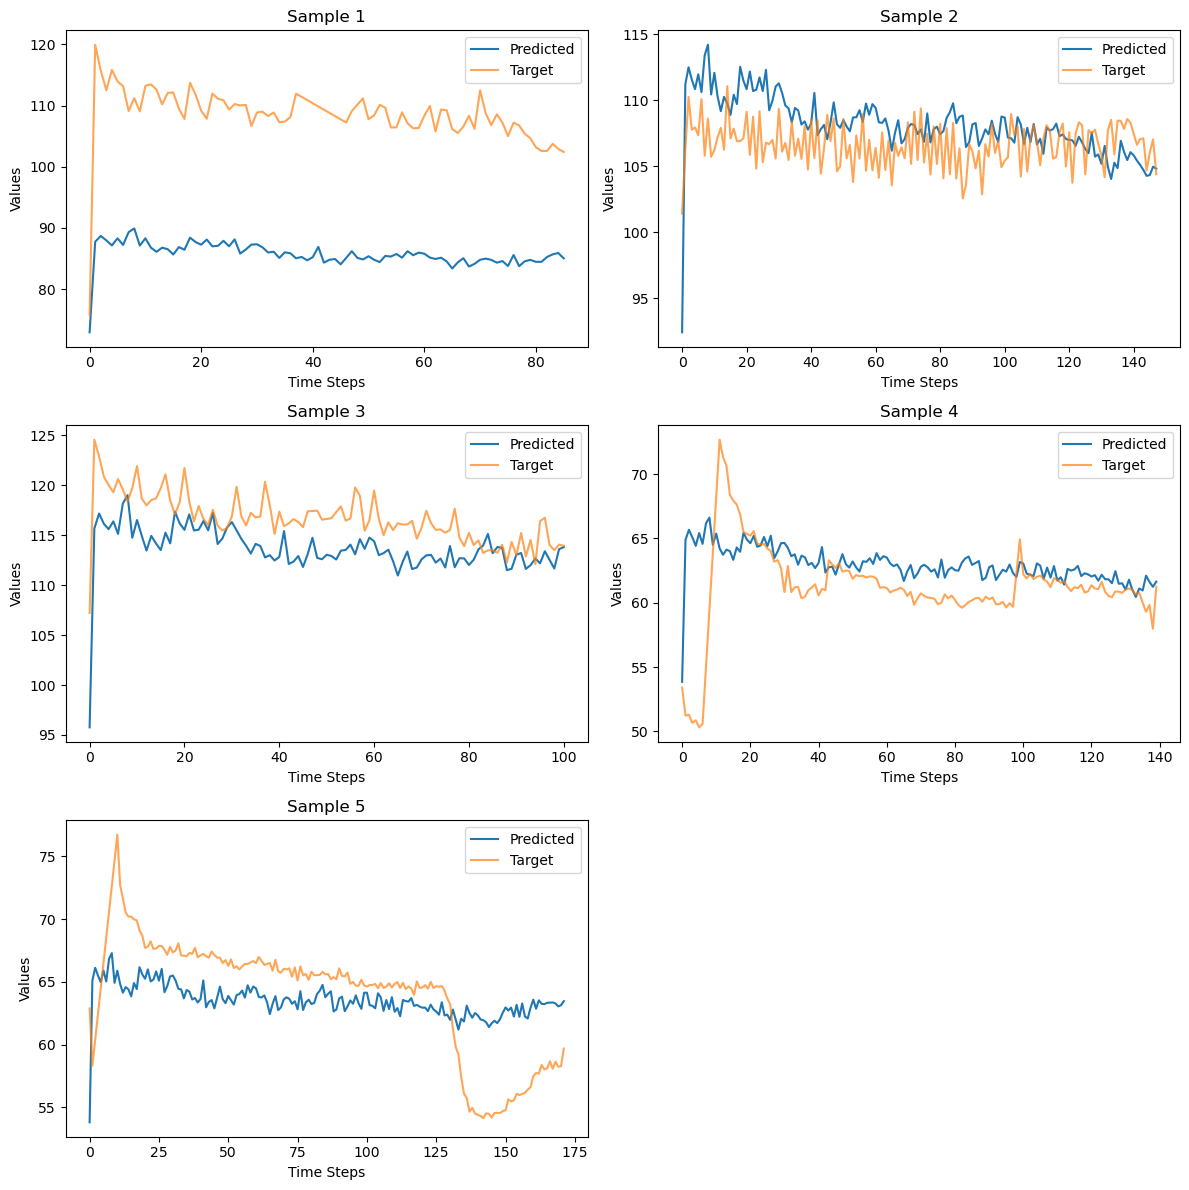

Test set: Average loss: 117.3264, Pearson's R: 0.9347698895839595


(226.3851745605469,
 191.28479375839234,
 117.32642269134521,
 0.9654910599958852,
 0.9347698895839595)

In [17]:
epochs = 200
model = HybridModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = nn.MSELoss()

train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

In [20]:
PR_val = []
PR_test = []
Train_loss = []
Test_loss = []
Val_loss = []
for i in np.random.choice(range(1, 201), 20, replace=False):
    print(f"seed: {i}")

    train_dataset, val_dataset, test_dataset = load_data(i)

    max_l = find_max_length_x()
    max_y_train = find_max_length_y(train_dataset)
    max_y_val = find_max_length_y(val_dataset)
    max_y_test = find_max_length_y(test_dataset)
    max_y = max(max_y_train, max_y_val, max_y_test)

    x_combine_train, y_train, y_len_train = set_dataset(train_dataset, max_l, max_y)
    x_combine_val, y_val, y_len_val = set_dataset(val_dataset, max_l, max_y)
    x_combine_test, y_test, y_len_test = set_dataset(test_dataset, max_l, max_y)

    train_loader = DataLoader(EVLPDataset(x_combine_train, y_train, y_len_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(EVLPDataset(x_combine_val, y_val, y_len_val), batch_size=1, shuffle=False)
    test_loader = DataLoader(EVLPDataset(x_combine_test, y_test, y_len_test), batch_size=1, shuffle=False)

    for m in [HybridModel(), CNN(num_in_channels=3)]:
        epochs = 200
        model = m.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
        criterion = nn.MSELoss()

        train_loss, val_loss, test_loss, pr_val, pr_test = train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
        PR_val.append(pr_val)
        PR_test.append(pr_test)
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Val_loss.append(val_loss)

    

2023-12-03 21:02:43,530 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


seed: 177


2023-12-03 21:02:43,586 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:02:43,616 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


143 5 6
length is 143
length is 5
length is 6
Epoch 200, Pearson's R: 0.554616853047837, Validation Loss: 868.1754686355591
Test set: Average loss: 213.1813, Pearson's R: 0.9045512514991081
Epoch 200, Pearson's R: 0.5756185687351205, Validation Loss: 815.7681385040283
Test set: Average loss: 253.9809, Pearson's R: 0.9434697836274589
seed: 34


2023-12-03 21:02:58,595 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301
2023-12-03 21:02:58,664 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:02:58,685 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


143 5 6
length is 143
length is 5
length is 6
Epoch 200, Pearson's R: 0.9663804702555502, Validation Loss: 47.921956825256345
Test set: Average loss: 40.0698, Pearson's R: 0.8971374779878276


2023-12-03 21:03:13,192 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.9528096468090952, Validation Loss: 65.34608540534973
Test set: Average loss: 81.7836, Pearson's R: 0.8025770293628823
seed: 122


2023-12-03 21:03:13,248 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:03:13,277 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


143 6 5
length is 143
length is 6
length is 5
Epoch 200, Pearson's R: 0.8783524227690567, Validation Loss: 49.53655751546224
Test set: Average loss: 119.1548, Pearson's R: 0.6398384277595506


2023-12-03 21:03:28,664 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.8634422917900474, Validation Loss: 62.747541745503746
Test set: Average loss: 166.8812, Pearson's R: 0.6487605377932597
seed: 181


2023-12-03 21:03:28,735 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:03:28,779 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


142 6 6
length is 142
length is 6
length is 6
Epoch 200, Pearson's R: 0.9682745540184808, Validation Loss: 229.50585746765137
Test set: Average loss: 33.5995, Pearson's R: 0.9051799807574155
Epoch 200, Pearson's R: 0.9358059297018468, Validation Loss: 360.976499915123
Test set: Average loss: 37.9734, Pearson's R: 0.895788153377417
seed: 103


2023-12-03 21:03:44,227 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:03:44,283 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:03:44,359 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


146 4 4
length is 146
length is 4
length is 4
Epoch 200, Pearson's R: 0.8395386531759091, Validation Loss: 238.46184730529785
Test set: Average loss: 405.1266, Pearson's R: 0.9641008460225251
Epoch 200, Pearson's R: 0.6541549302204748, Validation Loss: 87.46277189254761
Test set: Average loss: 187.2390, Pearson's R: 0.9717380433999441
seed: 136


2023-12-03 21:03:58,602 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:03:58,658 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:03:58,692 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


144 5 5
length is 144
length is 5
length is 5
Epoch 200, Pearson's R: 0.8161842473117221, Validation Loss: 220.75240020751954
Test set: Average loss: 332.1754, Pearson's R: 0.23980987862841613
Epoch 200, Pearson's R: 0.7800098267421268, Validation Loss: 216.8976722717285
Test set: Average loss: 262.7154, Pearson's R: 0.2547404001802348
seed: 89


2023-12-03 21:04:13,892 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:04:13,962 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:04:14,001 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


142 6 6
length is 142
length is 6
length is 6
Epoch 200, Pearson's R: 0.8251466282866506, Validation Loss: 236.82560920715332
Test set: Average loss: 399.3915, Pearson's R: 0.9797777187603671
Epoch 200, Pearson's R: 0.8626182760902755, Validation Loss: 166.5282408396403
Test set: Average loss: 281.2689, Pearson's R: 0.9750205205259543
seed: 77


2023-12-03 21:04:29,798 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:04:29,860 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:04:29,888 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


146 5 3
length is 146
length is 5
length is 3
Epoch 200, Pearson's R: 0.9937453259322127, Validation Loss: 61.38335075378418
Test set: Average loss: 67.4682, Pearson's R: 0.9795200276563613


2023-12-03 21:04:45,144 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.9884676257466514, Validation Loss: 175.33446502685547
Test set: Average loss: 87.2257, Pearson's R: 0.9181316767443536
seed: 66


2023-12-03 21:04:45,211 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:04:45,246 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


145 6 3
length is 145
length is 6
length is 3
Epoch 200, Pearson's R: 0.6035216541809275, Validation Loss: 152.4477809270223
Test set: Average loss: 99.8094, Pearson's R: 0.8312264410592529
Epoch 200, Pearson's R: 0.6296047826238176, Validation Loss: 150.34960508346558
Test set: Average loss: 164.1854, Pearson's R: 0.19989056137101685
seed: 125


2023-12-03 21:05:01,034 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:05:01,105 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:05:01,132 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


145 5 4
length is 145
length is 5
length is 4
Epoch 200, Pearson's R: 0.9299001843284598, Validation Loss: 90.48916215896607
Test set: Average loss: 83.2442, Pearson's R: 0.9650976904135644
Epoch 200, Pearson's R: 0.9345598723941564, Validation Loss: 107.9243236541748
Test set: Average loss: 135.2513, Pearson's R: 0.9062313490140429
seed: 108


2023-12-03 21:05:16,464 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:05:16,540 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:05:16,570 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


145 5 4
length is 145
length is 5
length is 4
Epoch 200, Pearson's R: 0.6322026903706011, Validation Loss: 51.4012414932251
Test set: Average loss: 329.8474, Pearson's R: 0.025871685793620435
Epoch 200, Pearson's R: 0.5827766720557571, Validation Loss: 96.41724090576172
Test set: Average loss: 214.0176, Pearson's R: 0.14452785648172933
seed: 127


2023-12-03 21:05:31,952 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:05:32,013 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:05:32,040 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


145 5 4
length is 145
length is 5
length is 4
Epoch 200, Pearson's R: 0.9603661020816963, Validation Loss: 135.42903604507447
Test set: Average loss: 136.6172, Pearson's R: 0.9110946815461549
Epoch 200, Pearson's R: 0.9403502025303223, Validation Loss: 240.71340255737306
Test set: Average loss: 220.6880, Pearson's R: 0.9035599395728062
seed: 5


2023-12-03 21:05:47,412 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-03 21:05:47,471 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:05:47,499 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


143 6 5
length is 143
length is 6
length is 5
Epoch 200, Pearson's R: 0.7579011474496491, Validation Loss: 196.07952316602072
Test set: Average loss: 306.2849, Pearson's R: 0.8080065419253466


2023-12-03 21:06:02,506 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.7421258765632697, Validation Loss: 405.7045160929362
Test set: Average loss: 772.4470, Pearson's R: 0.7772936350246431
seed: 169


2023-12-03 21:06:02,565 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:06:02,591 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


146 4 4
length is 146
length is 4
length is 4
Epoch 200, Pearson's R: 0.9232278674364444, Validation Loss: 366.0468349456787
Test set: Average loss: 86.7564, Pearson's R: 0.34399568130397273


2023-12-03 21:06:16,388 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.9451520014336741, Validation Loss: 191.12865352630615
Test set: Average loss: 294.0807, Pearson's R: 0.20972444842681534
seed: 162


2023-12-03 21:06:16,459 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:06:16,487 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


143 4 7
length is 143
length is 4
length is 7
Epoch 200, Pearson's R: 0.9535850925660418, Validation Loss: 78.97697234153748
Test set: Average loss: 1403.1001, Pearson's R: 0.857853158401753


2023-12-03 21:06:30,487 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.9290971647190387, Validation Loss: 128.78187942504883
Test set: Average loss: 1295.0316, Pearson's R: 0.8098208438860777
seed: 71


2023-12-03 21:06:30,550 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:06:30,577 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


144 4 6
length is 144
length is 4
length is 6
Epoch 200, Pearson's R: 0.9086229649511746, Validation Loss: 234.49095225334167
Test set: Average loss: 215.9852, Pearson's R: 0.984597639648054


2023-12-03 21:06:44,804 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.9169806230072853, Validation Loss: 383.3208427429199
Test set: Average loss: 284.6585, Pearson's R: 0.9630580636858025
seed: 83


2023-12-03 21:06:44,866 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:06:44,890 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


147 3 4
length is 147
length is 3
length is 4
Epoch 200, Pearson's R: 0.7427310216790026, Validation Loss: 125.76154232025146
Test set: Average loss: 191.7954, Pearson's R: 0.7623733960398131


2023-12-03 21:06:58,575 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.3424761866330368, Validation Loss: 203.9871063232422
Test set: Average loss: 322.9518, Pearson's R: 0.6244617743568883
seed: 81


2023-12-03 21:06:58,637 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:06:58,662 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


144 5 5
length is 144
length is 5
length is 5
Epoch 200, Pearson's R: 0.3084796251562409, Validation Loss: 53.26007995605469
Test set: Average loss: 85.0549, Pearson's R: 0.8869711364181164


2023-12-03 21:07:13,944 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.10419113367558641, Validation Loss: 251.14318923950196
Test set: Average loss: 348.3211, Pearson's R: 0.737252933980347
seed: 10


2023-12-03 21:07:14,021 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:07:14,048 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


142 7 5
length is 142
length is 7
length is 5
Epoch 200, Pearson's R: 0.746006480501317, Validation Loss: 1244.4141906329564
Test set: Average loss: 71.4007, Pearson's R: 0.7645429030606126


2023-12-03 21:07:32,513 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626


Epoch 200, Pearson's R: 0.7615784042492245, Validation Loss: 1241.4004118783134
Test set: Average loss: 127.5585, Pearson's R: 0.794482167095027
seed: 105


2023-12-03 21:07:32,583 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-03 21:07:32,613 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


144 6 4
length is 144
length is 6
length is 4
Epoch 200, Pearson's R: 0.6985260604236254, Validation Loss: 361.682035446167
Test set: Average loss: 280.9191, Pearson's R: 0.7202200262925765
Epoch 200, Pearson's R: 0.7489510759361114, Validation Loss: 860.2317301432291
Test set: Average loss: 876.6372, Pearson's R: 0.6874926619300585


Validation peasonR hybrid mean: 0.80036550229613, peasonR CNN mean: 0.7595385545828459
Test peasonR hybrid mean: 0.7685883295487205, peasonR CNN mean: 0.7084011189918379
Validation loss hybrid mean: 252.152119980199, peasonR CNN mean: 310.60821585865244
Test loss hybrid mean: 245.04910997573816, peasonR CNN mean: 320.74484341581666


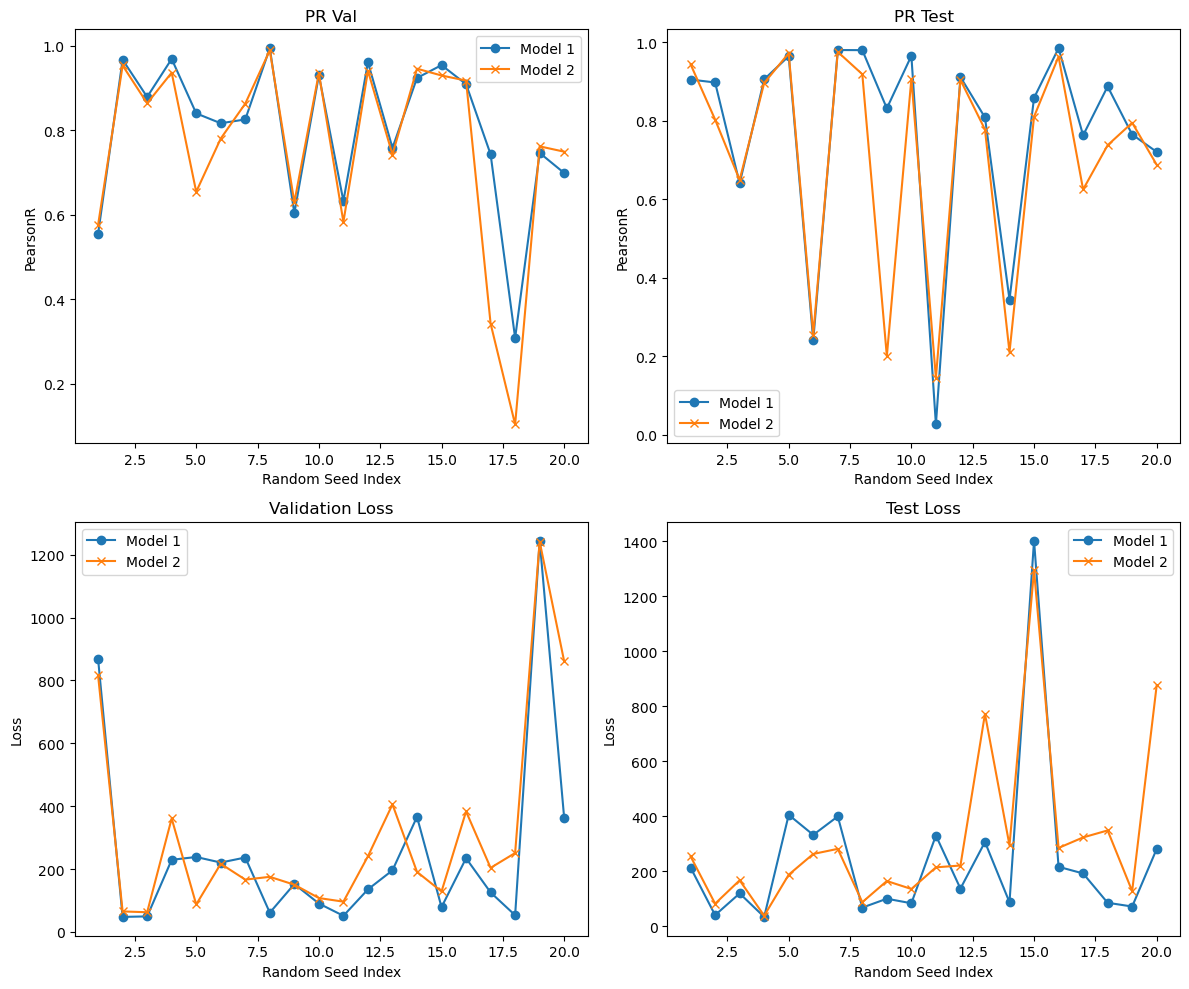

In [21]:
# Extracting values for the two models
PR_val_model1 = PR_val[::2]
PR_val_model2 = PR_val[1::2]
PR_test_model1 = PR_test[::2]
PR_test_model2 = PR_test[1::2]
Val_loss_model1 = Val_loss[::2]
Val_loss_model2 = Val_loss[1::2]
Test_loss_model1 = Test_loss[::2]
Test_loss_model2 = Test_loss[1::2]

print(f"Validation peasonR hybrid mean: {np.mean(PR_val_model1)}, peasonR CNN mean: {np.mean(PR_val_model2)}")
print(f"Test peasonR hybrid mean: {np.mean(PR_test_model1)}, peasonR CNN mean: {np.mean(PR_test_model2)}")
print(f"Validation loss hybrid mean: {np.mean(Val_loss_model1)}, peasonR CNN mean: {np.mean(Val_loss_model2)}")
print(f"Test loss hybrid mean: {np.mean(Test_loss_model1)}, peasonR CNN mean: {np.mean(Test_loss_model2)}")

# Random seed indices (assuming equal length for all lists)
indices = range(1, len(PR_val_model1) + 1)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# PR_val plot
axs[0, 0].plot(indices, PR_val_model1, label='Model 1', marker='o')
axs[0, 0].plot(indices, PR_val_model2, label='Model 2', marker='x')
axs[0, 0].set_title('PR Val')
axs[0, 0].set_xlabel('Random Seed Index')
axs[0, 0].set_ylabel('PearsonR')
axs[0, 0].legend()

# PR_test plot
axs[0, 1].plot(indices, PR_test_model1, label='Model 1', marker='o')
axs[0, 1].plot(indices, PR_test_model2, label='Model 2', marker='x')
axs[0, 1].set_title('PR Test')
axs[0, 1].set_xlabel('Random Seed Index')
axs[0, 1].set_ylabel('PearsonR')
axs[0, 1].legend()

# Val_loss plot
axs[1, 0].plot(indices, Val_loss_model1, label='Model 1', marker='o')
axs[1, 0].plot(indices, Val_loss_model2, label='Model 2', marker='x')
axs[1, 0].set_title('Validation Loss')
axs[1, 0].set_xlabel('Random Seed Index')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Test_loss plot
axs[1, 1].plot(indices, Test_loss_model1, label='Model 1', marker='o')
axs[1, 1].plot(indices, Test_loss_model2, label='Model 2', marker='x')
axs[1, 1].set_title('Test Loss')
axs[1, 1].set_xlabel('Random Seed Index')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

# Adjusting layout
plt.tight_layout()
plt.show()
